<a href="https://colab.research.google.com/github/jdavidmontes-hub/Dise-o-y-Optimizaci-n-de-un-Sistema-de-Energ-a-Solar/blob/main/Simulaci%C3%B3n_de_Sistema_de_Energ%C3%ADa_Solar_con_24_Horas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduce la latitud (ej. 6.2442 para Medellín): 6.2
Introduce la longitud (ej. -75.5812 para Medellín): -75.5
Introduce la fecha (YYYY-MM-DD): 2020-08-23
Introduce la inclinación del panel en grados (ej. 20): 20
Introduce el acimut del panel en grados (0=N, 90=E, 180=S, 270=O; ej. 180): 180


/tmp/ipython-input-3017584182.py:39: RuntimeWarning: invalid value encountered in arccos
  acimut = np.rad2deg(np.arccos((np.sin(np.deg2rad(altitud)) * np.sin(np.deg2rad(lat)) - np.sin(np.deg2rad(declination))) /


Los datos de la simulación se han guardado en 'Simulacion_Solar_2020-08-23.xlsx'


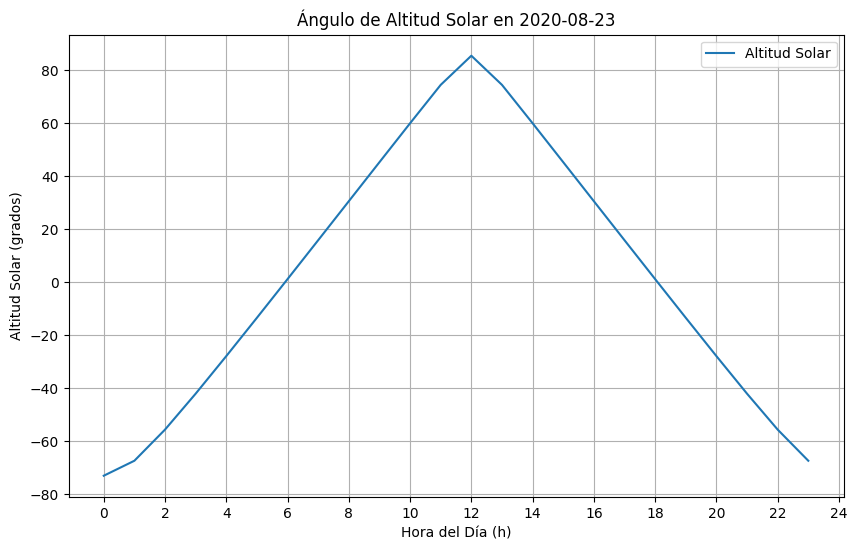

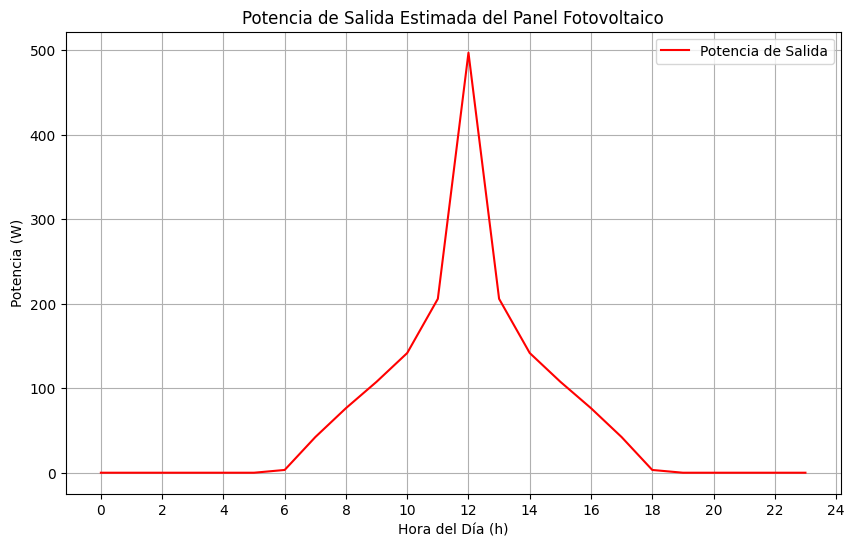

Potencia máxima estimada: 497.02 W
Energía diaria total estimada: 1.65 kWh


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pandas as pd

# --- 1. Parámetros de Entrada del Usuario ---
try:
    latitud = float(input("Introduce la latitud (ej. 6.2442 para Medellín): "))
    longitud = float(input("Introduce la longitud (ej. -75.5812 para Medellín): "))

    fecha_str = input("Introduce la fecha (YYYY-MM-DD): ")
    fecha_base = datetime.strptime(fecha_str, '%Y-%m-%d')


    inclinacion_panel = float(input("Introduce la inclinación del panel en grados (ej. 20): "))
    acimut_panel = float(input("Introduce el acimut del panel en grados (0=N, 90=E, 180=S, 270=O; ej. 180): "))

except ValueError:
    print("Error: Por favor, introduce valores numéricos válidos.")
    exit()

# Parámetros del panel solar para la simulación
eficiencia_panel = 0.20
area_panel = 1.6

# --- 2. Funciones para los Cálculos ---

def calcular_posicion_solar(lat, lon, fecha):
    """Calcula el acimut y la altitud solar para una fecha, hora y ubicación dadas."""
    dia_del_año = fecha.timetuple().tm_yday
    hora = fecha.hour + fecha.minute / 60 + fecha.second / 3600

    declination = 23.45 * np.sin(np.deg2rad(360/365 * (284 + dia_del_año)))
    hour_angle = 15 * (hora - 12)

    altitud = np.rad2deg(np.arcsin(np.sin(np.deg2rad(lat)) * np.sin(np.deg2rad(declination)) +
                                     np.cos(np.deg2rad(lat)) * np.cos(np.deg2rad(declination)) * np.cos(np.deg2rad(hour_angle))))

    acimut = np.rad2deg(np.arccos((np.sin(np.deg2rad(altitud)) * np.sin(np.deg2rad(lat)) - np.sin(np.deg2rad(declination))) /
                                     (np.cos(np.deg2rad(altitud)) * np.cos(np.deg2rad(lat)))))

    if hour_angle > 0:
        acimut = 360 - acimut

    return altitud, acimut

def calcular_irradiancia_en_panel(altitud_sol, acimut_sol, inclinacion_panel, acimut_panel):
    """Estima la irradiancia en un panel inclinado (modelo simplificado)."""
    Gsc = 1367

    irradiancia_directa = Gsc * np.sin(np.deg2rad(altitud_sol))
    irradiancia_difusa = 0.2 * irradiancia_directa

    irradiancia_total_inclinada = irradiancia_directa * np.cos(np.deg2rad(inclinacion_panel)) * np.cos(np.deg2rad(acimut_sol - acimut_panel)) + irradiancia_difusa

    return max(0, irradiancia_total_inclinada)

# --- 3. Simulación y Recopilación de Datos ---
horas_del_dia = np.arange(0, 24, 1)  # Intervalo de 1 hora
datos = []

for h in horas_del_dia:
    hora_actual = fecha_base + timedelta(hours=float(h))
    altitud, acimut = calcular_posicion_solar(latitud, longitud, hora_actual)

    potencia = 0
    if altitud > 0:
        irradiancia = calcular_irradiancia_en_panel(altitud, acimut, inclinacion_panel, acimut_panel)
        potencia = irradiancia * eficiencia_panel * area_panel

    fecha = hora_actual.strftime('%Y-%m-%d')
    hora = hora_actual.strftime('%H:%M')

    datos.append({'Fecha': fecha, 'Hora': hora, 'Latitud': latitud, 'Longitud': longitud,
                  'Inclinacion_Panel': inclinacion_panel, 'Acimut_Panel': acimut_panel,
                  'Altitud_Solar': altitud, 'Acimut_Solar': acimut, 'Potencia_Generada_W': potencia})


# --- 4. Exportar a Excel ---
df = pd.DataFrame(datos)
nombre_archivo = f'Simulacion_Solar_{fecha_base.strftime("%Y-%m-%d")}.xlsx'
df.to_excel(nombre_archivo, index=False)
print(f"Los datos de la simulación se han guardado en '{nombre_archivo}'")

# --- 5. Visualización de Datos ---
horas_del_dia_plot = np.arange(0, 24, 1)
altitudes_solares_plot = [d['Altitud_Solar'] for d in datos]
potencias_salida_plot = [d['Potencia_Generada_W'] for d in datos]

plt.figure(figsize=(10, 6))
plt.plot(horas_del_dia_plot, altitudes_solares_plot, label='Altitud Solar')
plt.title(f'Ángulo de Altitud Solar en {fecha_base.strftime("%Y-%m-%d")}')
plt.xlabel('Hora del Día (h)')
plt.ylabel('Altitud Solar (grados)')
plt.xticks(np.arange(0, 25, 2))  # Muestra etiquetas cada 2 horas (0, 2, 4...)
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(horas_del_dia_plot, potencias_salida_plot, label='Potencia de Salida', color='red')
plt.title(f'Potencia de Salida Estimada del Panel Fotovoltaico')
plt.xlabel('Hora del Día (h)')
plt.ylabel('Potencia (W)')
plt.xticks(np.arange(0, 25, 2)) # Muestra etiquetas cada 2 horas (0, 2, 4...)
plt.grid(True)
plt.legend()
plt.show()

print(f"Potencia máxima estimada: {max(potencias_salida_plot):.2f} W")
print(f"Energía diaria total estimada: {np.sum(potencias_salida_plot) / 1000:.2f} kWh")

eof

### Explicación de los Cambios

La única modificación significativa se encuentra en la función `visualizar_resultados`. He añadido la siguiente línea de código a ambos gráficos (`ax1` y `ax2`):

In [ ]:
ax.set_xticks(np.arange(0, 24, 2))

# Task
Refactor the provided Python code for simulating a solar panel system to simplify its structure, following the organizational principles of the provided "Picas y Fijas" game code. The refactored code should maintain all existing functionalities, including user input for date, time, location, panel type, and panel area, calculations for solar position and irradiance, simulation over a 24-hour period, data export to Excel, and data visualization with two plots. The refactoring should focus on breaking down the code into logical functions for better readability and maintainability.

## Definir una función principal

### Subtask:
Crear una función principal que orqueste la ejecución de la simulación.


**Reasoning**:
Define the main function to orchestrate the simulation.



In [ ]:
def main():
    """Orquesta la ejecución de la simulación del sistema solar."""
    # This is where we will call other functions to perform the simulation steps.
    pass


## Crear una función para la entrada de datos

### Subtask:
Extraer el código de entrada de usuario en una función separada.


**Reasoning**:
Define a function to handle user input and incorporate the error handling.



In [ ]:
def obtener_parametros_entrada():
    """Obtiene los parámetros de entrada del usuario."""
    try:
        latitud = float(input("Introduce la latitud (ej. 6.2442 para Medellín): "))
        longitud = float(input("Introduce la longitud (ej. -75.5812 para Medellín): "))

        fecha_str = input("Introduce la fecha (YYYY-MM-DD): ")
        fecha_base = datetime.strptime(fecha_str, '%Y-%m-%d')

        inclinacion_panel = float(input("Introduce la inclinación del panel en grados (ej. 20): "))
        acimut_panel = float(input("Introduce el acimut del panel en grados (0=N, 90=E, 180=S, 270=O; ej. 180): "))

        return latitud, longitud, fecha_base, inclinacion_panel, acimut_panel

    except ValueError:
        print("Error: Por favor, introduce valores numéricos válidos.")
        return None, None, None, None, None

def main():
    """Orquesta la ejecución de la simulación del sistema solar."""
    latitud, longitud, fecha_base, inclinacion_panel, acimut_panel = obtener_parametros_entrada()

    if latitud is None:
        return # Exit if input was invalid

    # Parámetros del panel solar para la simulación
    eficiencia_panel = 0.20
    area_panel = 1.6

    # Rest of the simulation logic will go here in subsequent steps
    print("Input parameters collected successfully.")

main()

Introduce la latitud (ej. 6.2442 para Medellín): 6.2
Introduce la longitud (ej. -75.5812 para Medellín): -75.5
Introduce la fecha (YYYY-MM-DD): 2020-02-23
Introduce la inclinación del panel en grados (ej. 20): 20
Introduce el acimut del panel en grados (0=N, 90=E, 180=S, 270=O; ej. 180): 180
Input parameters collected successfully.


## Crear una función para la simulación

### Subtask:
Agrupar el bucle de simulación y la recopilación de datos en una función.


**Reasoning**:
Define a new function `ejecutar_simulacion` that encapsulates the simulation loop and data collection, taking the necessary parameters as arguments.

